In [32]:
# Import the libaray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report



In [33]:
df= pd.read_csv("kl.csv", encoding='ISO-8859-1')

In [34]:
# --- Add new engineered features based on FIFA stats ---

# Convert Height and Weight to numeric for calculations
df['Height'] = df['Height'].str.replace("'", '.').astype(float)
df['Weight'] = df['Weight'].str.replace('lbs', '').astype(float)

# Create meaningful combined features
df['attack_to_defense_ratio'] = (df['Finishing'] + df['Positioning']) / (df['Interceptions'] + df['StandingTackle'] + 1)
df['passing_quality'] = (df['ShortPassing'] + df['LongPassing'] + df['Vision']) / 3
df['physical_dominance'] = (df['Strength'] + df['Stamina'] + df['Jumping']) / 3

print("✅ Added new features: attack_to_defense_ratio, passing_quality, physical_dominance")


✅ Added new features: attack_to_defense_ratio, passing_quality, physical_dominance


In [35]:
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,attack_to_defense_ratio,passing_quality,physical_dominance
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,26.0,6.0,11.0,15.0,14.0,8.0,226.5M,3.705882,90.333333,66.333333
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,23.0,7.0,11.0,15.0,14.0,11.0,127.1M,3.098361,80.000000,87.333333
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,33.0,9.0,9.0,15.0,15.0,11.0,228.1M,2.885246,83.000000,63.666667
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,13.0,90.0,85.0,87.0,88.0,94.0,138.6M,0.480769,56.333333,58.000000
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,51.0,15.0,13.0,5.0,10.0,13.0,196.4M,1.408333,92.333333,76.000000


In [36]:
# --- Handle missing values ---
print("Missing values before:", df.isnull().sum().sum())

# Fill all numeric columns with median values
df.fillna(df.median(numeric_only=True), inplace=True)

print("Missing values after:", df.isnull().sum().sum())
print("Missing data handled successfully")


Missing values before: 77130
Missing values after: 75052
Missing data handled successfully


In [37]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [38]:
df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

Cleaning the data

In [39]:
df.isnull().sum().sort_values(ascending=False).head(15)

Loaned From    16943
CDM             2085
LS              2085
RS              2085
LF              2085
CF              2085
RF              2085
RW              2085
LAM             2085
CAM             2085
RAM             2085
LM              2085
LCM             2085
CM              2085
RCM             2085
dtype: int64

In [40]:
#Removing columns that are redunant
df_cleaned = df.drop(columns=[
    'ID', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Body Type',
    'Joined', 'Loaned From', 'Contract Valid Until', 'Jersey Number',
    'Release Clause'
], errors='ignore')

print("Shape after dropping irrelevant columns:", df_cleaned.shape)


Shape after dropping irrelevant columns: (18207, 81)


Filing the missing numeric and catergorical values

In [41]:
# Filling missing numeric values with the column mean
numeric_cols = df_cleaned.select_dtypes(include='number').columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].mean())

# Filling missing categorical values with the most common entry
categorical_cols = df_cleaned.select_dtypes(include='object').columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna(df_cleaned[categorical_cols].mode().iloc[0])


In [42]:
#Simplifying the positions into labels for the model
# Create Simplified_Role if it doesn't exist
if 'Simplified_Role' not in df_cleaned.columns:
    def simplify_role(pos):
        if pos in ['ST', 'CF', 'LW', 'RW', 'LF', 'RF']:
            return 'Attacker'
        elif pos in ['CM', 'CAM', 'CDM', 'RM', 'LM']:
            return 'Midfielder'
        elif pos in ['CB', 'LB', 'RB', 'LWB', 'RWB']:
            return 'Defender'
        else:
            return 'Other'
    df_cleaned['Simplified_Role'] = df_cleaned['Position'].apply(simplify_role)


Feature Scaling

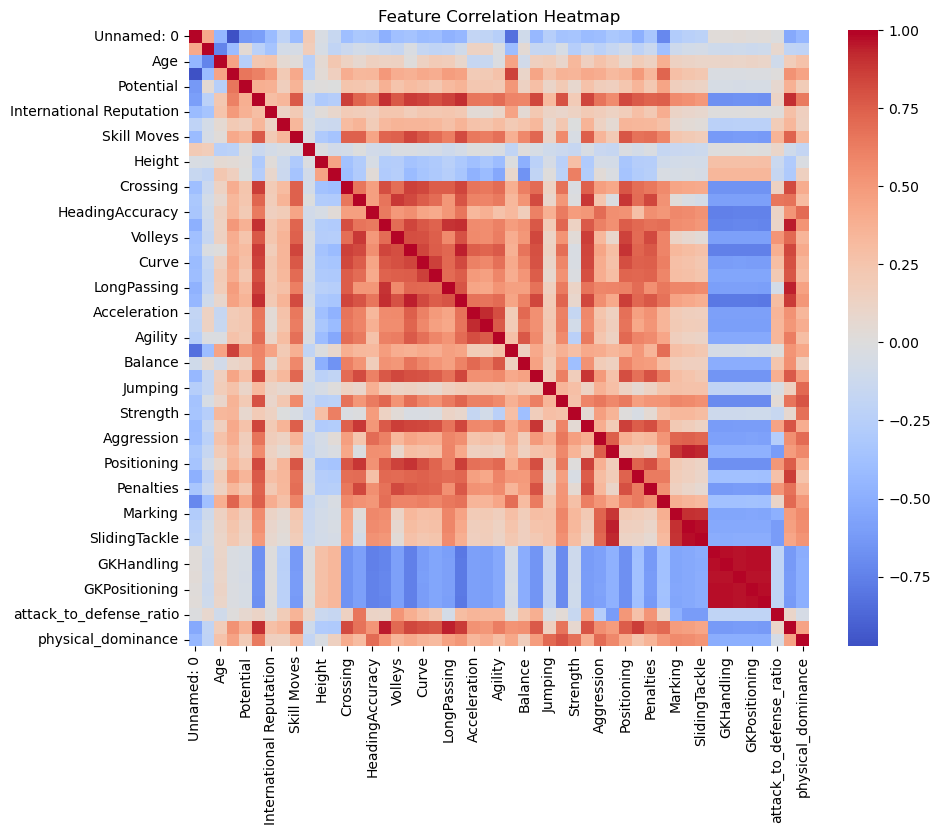

✅ Dropped highly correlated features: ['ShortPassing', 'BallControl', 'SprintSpeed', 'StandingTackle', 'SlidingTackle', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'passing_quality']


In [43]:
# Keep only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Drop highly correlated (> 0.9) columns to reduce redundancy
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df.drop(columns=to_drop, inplace=True)

print("✅ Dropped highly correlated features:", to_drop)


In [44]:
# --- Ensure all features used are numeric ---
import numpy as np

X = df.select_dtypes(include=[np.number])

# Double-check for non-numeric values
non_numeric_cols = X.columns[X.isin([np.nan, np.inf, -np.inf]).any()]
print("⚠️ Non-numeric columns found:", non_numeric_cols.tolist())

# Drop any rows with invalid (non-numeric) data
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Re-scale clean numeric data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Clean numeric dataset ready for K-Means. Shape:", X_scaled.shape)


⚠️ Non-numeric columns found: []
✅ Clean numeric dataset ready for K-Means. Shape: (18207, 39)


In [45]:
# --- Scale numeric features ---
from sklearn.preprocessing import StandardScaler

# Select only numeric columns for clustering
X = df.select_dtypes(include=['number'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Data scaled successfully! Shape:", X_scaled.shape)


✅ Data scaled successfully! Shape: (18207, 39)


In [46]:
# --- Apply K-Means Clustering ---
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Choose number of clusters (start with 3 or 4)
k = 3

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Assign cluster labels back to dataset
df['Cluster'] = kmeans.labels_

print("✅ K-Means clustering done with", k, "clusters!")
print(df['Cluster'].value_counts())


✅ K-Means clustering done with 3 clusters!
Cluster
0    8312
2    7865
1    2030
Name: count, dtype: int64


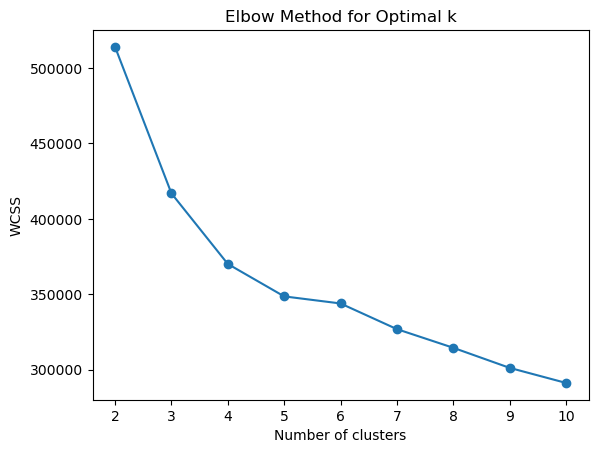

In [47]:
# --- Elbow Method to determine best K ---
wcss = []  # Within-cluster sum of squares

for i in range(2, 11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


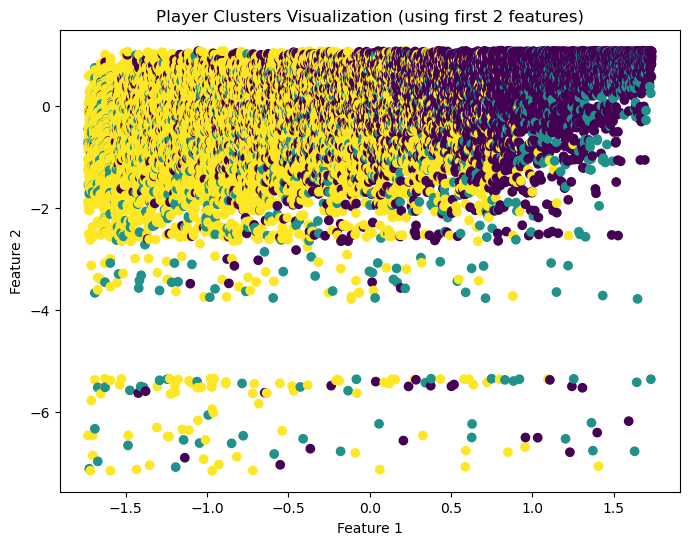

In [48]:
# --- Visualize clusters using first 2 features (for simplicity) ---
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Player Clusters Visualization (using first 2 features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [51]:
# --- Evaluate K-Means Clustering Performance ---

from sklearn.metrics import silhouette_score, f1_score, accuracy_score
import numpy as np

# Check if X_scaled is a numpy array and handle accordingly
if isinstance(X_scaled, np.ndarray):
    # NumPy arrays are already numeric, so we can use X_scaled directly
    X_scaled_numeric = X_scaled
else:
    # If it's a DataFrame, select numeric columns
    X_scaled_numeric = X_scaled.select_dtypes(include=['float64', 'int64'])

# Silhouette measures how well the data points fit within their clusters
silhouette = silhouette_score(X_scaled_numeric, kmeans.labels_)

# If you have actual player roles to compare against (e.g. 'Position'), map clusters to those roles
if 'Position' in df.columns:
    # Create a quick mapping of cluster labels to the most frequent Position in each cluster
    cluster_role_map = df.groupby('Cluster')['Position'].agg(lambda x: x.value_counts().index[0]).to_dict()
    df['Predicted_Role_Mapped'] = df['Cluster'].map(cluster_role_map)

    # Calculate evaluation metrics based on that mapping
    # Ensure both columns are of the same type (strings)
    df['Position'] = df['Position'].astype(str)
    df['Predicted_Role_Mapped'] = df['Predicted_Role_Mapped'].astype(str)
    
    f1 = f1_score(df['Position'], df['Predicted_Role_Mapped'], average='weighted')
    acc = accuracy_score(df['Position'], df['Predicted_Role_Mapped'])
else:
    f1 = None
    acc = None

# Print out model performance
print("🔍 K-Means Model Performance Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
if f1 is not None and acc is not None:
    print(f"F1 Score: {f1:.3f}")
    print(f"Accuracy: {acc:.3f}")
else:
    print("F1 Score & Accuracy skipped (no true role labels available)")

🔍 K-Means Model Performance Metrics:
Silhouette Score: 0.206
F1 Score: 0.167
Accuracy: 0.258
